## 0. Code Setup and Helper Functions

### 0.1 Import all necessary packages

In [3]:
import os
import zlib
import pickle as pkl
import sklearn
import pandas as pd
from tabulate import tabulate
from top2vec import Top2Vec

### 0.2 Path Adjustments

In [4]:
if os.getcwd().endswith('/notebooks'):
    os.chdir('..')

assert os.path.exists('./src'), f"[ERROR] The path src not detected in the current directory '{os.getcwd()}'."

print(f'[INFO] Current Directory: "{os.getcwd()}".')

[INFO] Current Directory: "/home/iceking/Desktop/22SS-TUM Lecture Docs/3. Master's Practical Course - Machine Learning for Natural Language Processing Applications (IN2106, IN4249)/Repo/topic-modeling-advancements".


## 1. Main Part

In [6]:
import src.top2vec_runner as top2vec_runner 

# Alternatives: ['doc2vec', 'universal-sentence-encoder', 'universal-sentence-encoder-large',
# 'universal-sentence-encoder-multilingual', 'universal-sentence-encoder-multilingual-large',
# 'distiluse-base-multilingual-cased', 'all-MiniLM-L6-v2', 'paraphrase-multilingual-MiniLM-L12-v2']
args = {
    'dataset_dir': './data/crisis_resource_01_labeled_by_paid_workers',
    'data_col': 'tweet_text',
    # 'dataset_dir': './data/crisis_resource_12_labeled_by_paid_workers',
    # 'data_col': 'text',
    # 'dataset_dir': './data/20news_bydate',
    'speed': 'learn',  # Options: ['fast-learn', 'learn', 'deep-learn']
    'embedding_model': 'doc2vec',
    'num_topics': 4,  # Options: None or integer
}
t2v_model, topic_stats = top2vec_runner.run(**args)

2022-05-19 21:56:36,840 - top2vec - INFO - Pre-processing documents for training


[INFO] Top2Vec Parameters:
    > Input Dataset Directory:"./data/crisis_resource_01_labeled_by_paid_workers".
    > Input Dataset Data Column:"tweet_text".
    > Model Speed:"fast-learn".
    > Model Embedding Model:doc2vec.
    > Pre-specified Number of Topics:4.
[INFO] Top2Vec is running for dataset directory:"./data/crisis_resource_01_labeled_by_paid_workers".


2022-05-19 21:56:37,580 - top2vec - INFO - Creating joint document/word embedding
2022-05-19 21:57:43,477 - top2vec - INFO - Creating lower dimension embedding of documents
2022-05-19 21:58:10,867 - top2vec - INFO - Finding dense areas of documents
2022-05-19 21:58:12,850 - top2vec - INFO - Finding topics


[INFO] Original (Non-reduced) Number of Topics: 2.
[WARN] # of topics is pre-specified but non_reduced_num_topics <= num_topics, so not reduced!
   > non_reduced_num_topics:2, given num_topics:4!
[INFO] Topic #00:
     > From Reduced Model:False.
     > Topic Size:22075.
     > Topic Words: ['sea' 'america' 'ago' 'details' 'post' 'htt' 'evacuation' 'small' 'am'
		 'shows' 'advisory' 'ur' 'info' 'oh' 'declared' 'facebook' 'social' 'near'
		 'red' 'real' 'climate' 'baby' 'japan' 'photo' 'system' 'signal' 'track'
		 'ok' 'images' 'earthquakes' 'little' 'american' 'drone' 'injuries'
		 'threat' 'report' 'nathan' 'earth' 'map' 'yesterday' 'cnn' 'update' 'eye'
		 'five' 'jim' 'aftermath' 'tuesday' 'office' 'following' 'rocks']
     > Topic Word Scores: [0.9950365  0.99365616 0.9936558  0.9928652  0.99284357 0.9911123
		 0.9906199  0.99019355 0.99017465 0.98912317 0.98860395 0.9885863
		 0.98858285 0.988263   0.98707205 0.98674065 0.98617953 0.9856501
		 0.985425   0.985186   0.9848958  0.984

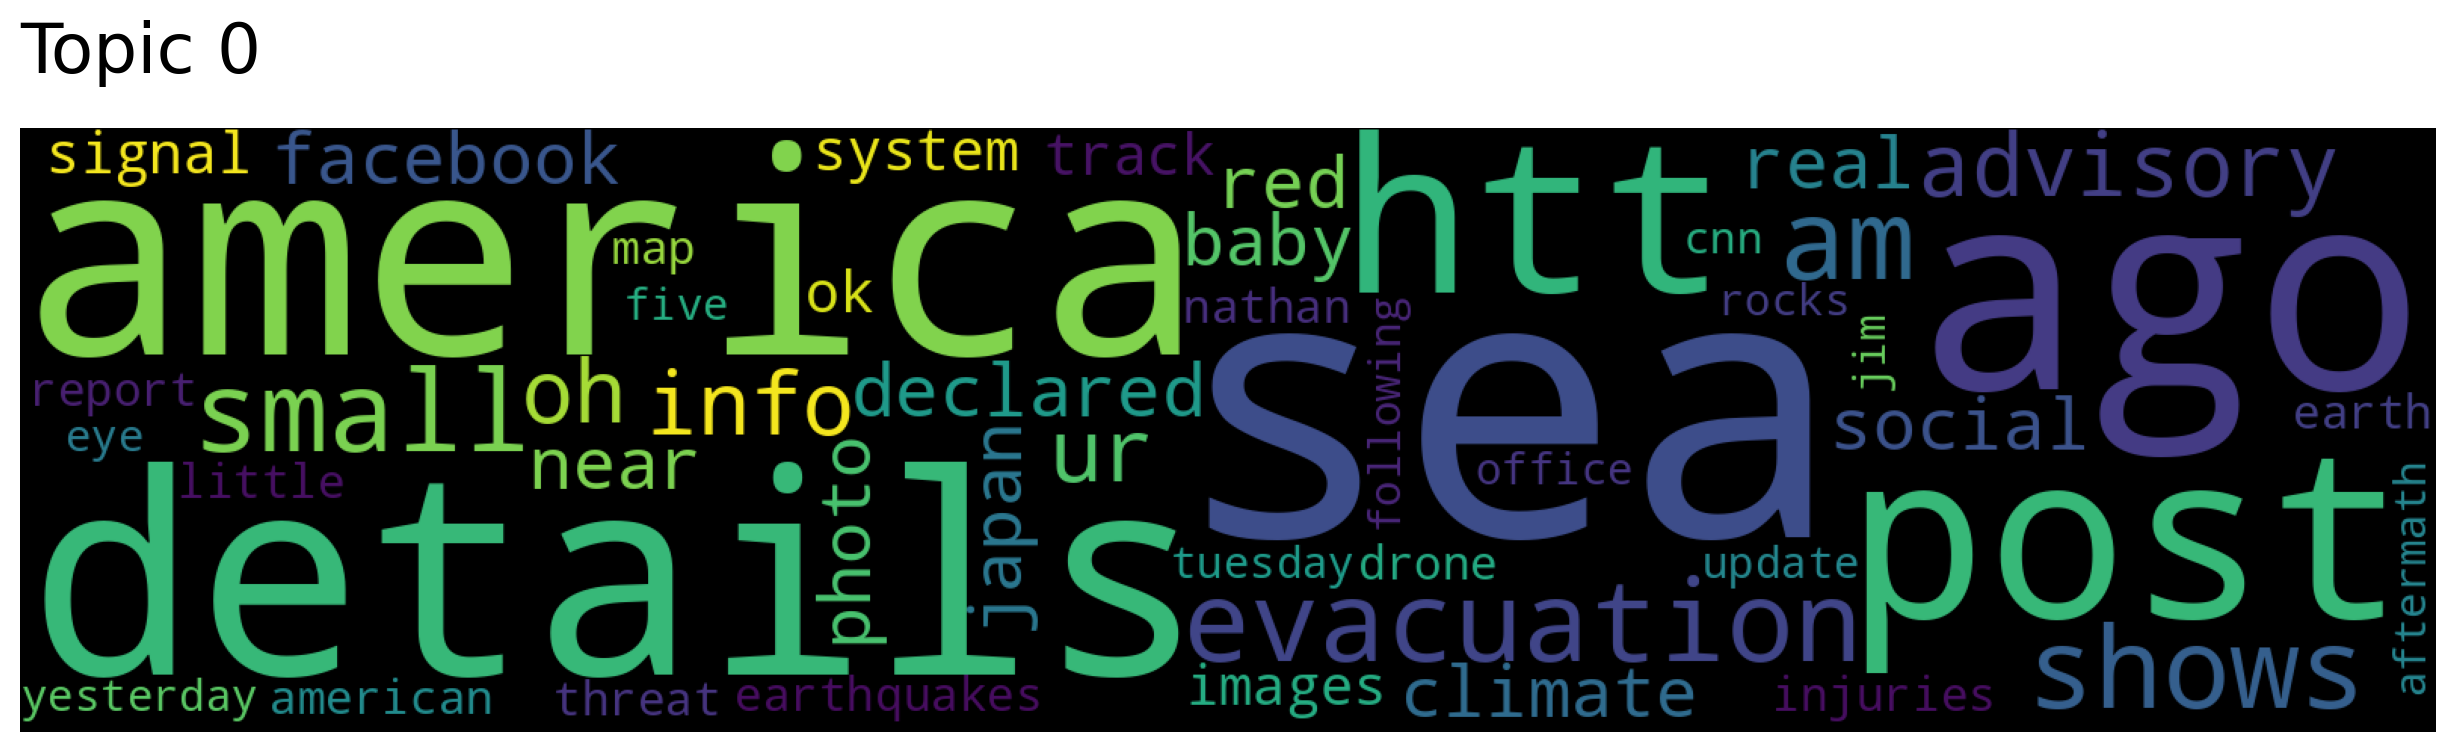

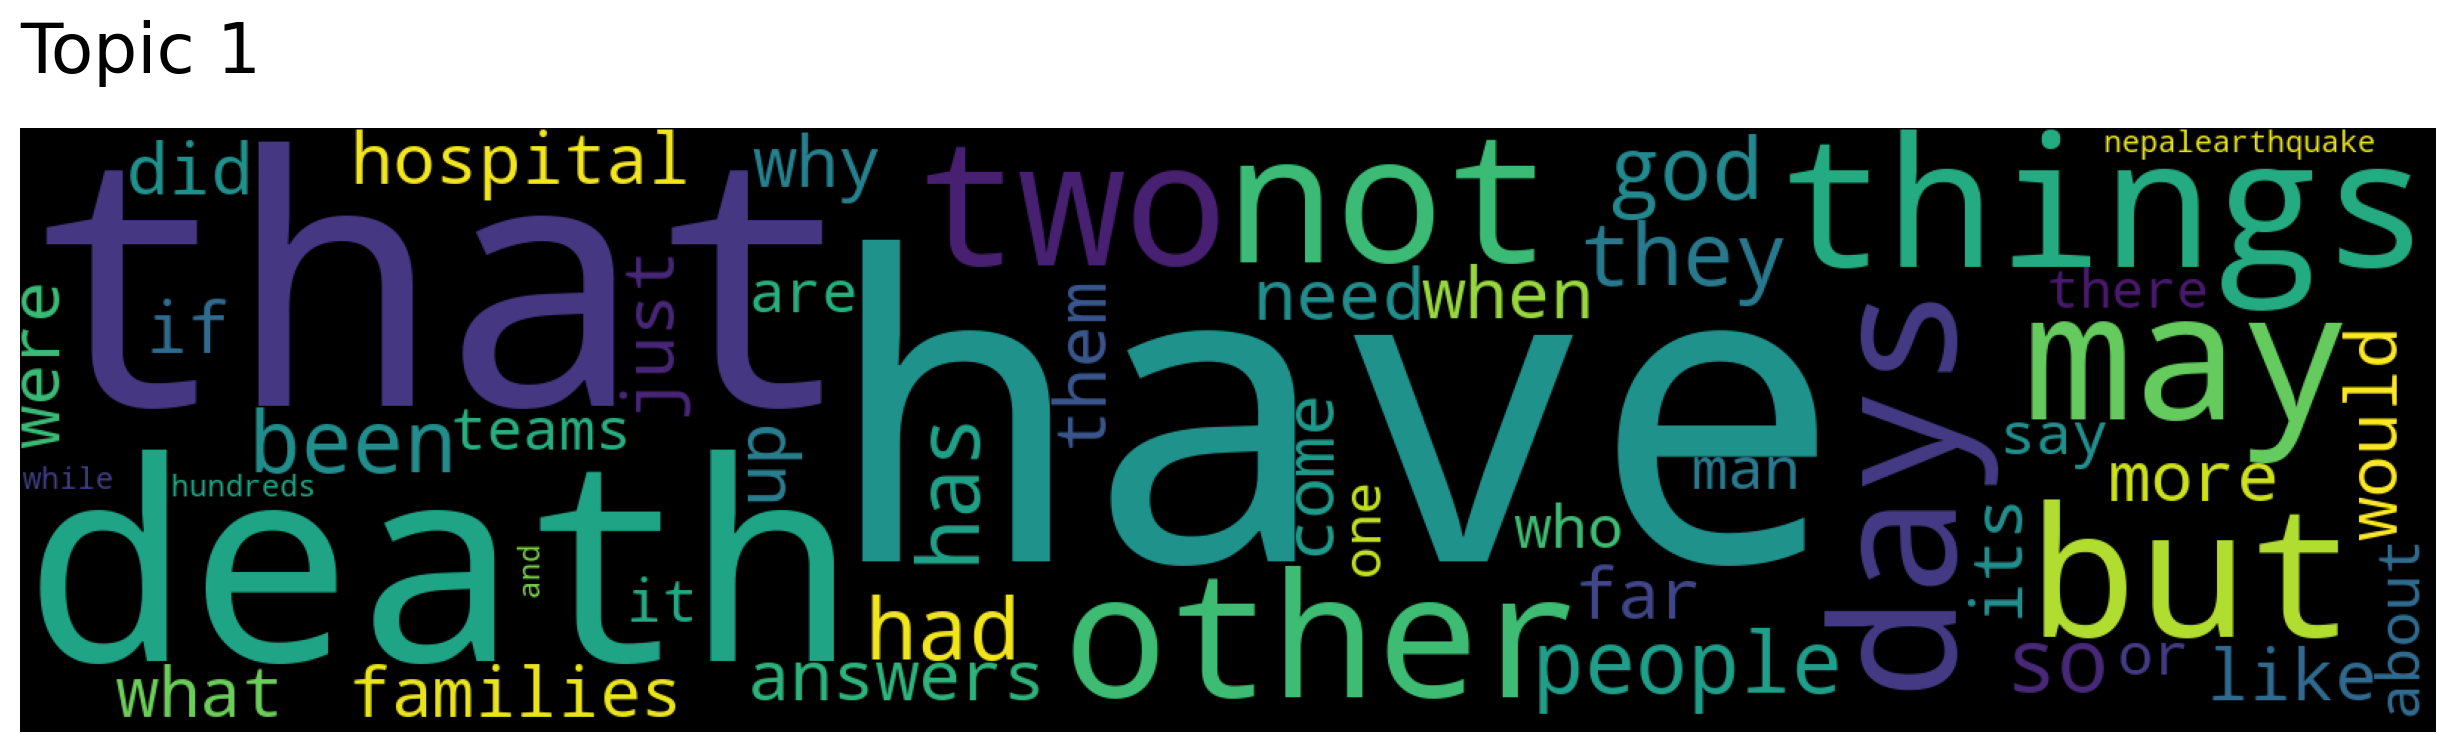

In [11]:
for topic_stat in topic_stats:
    t2v_model.generate_topic_wordcloud(topic_stat['topic_num'])